In [30]:
#imports, nothing to see here
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
%matplotlib inline

## 有 10 台拉霸機可供選擇，找出最高勝率的玩法

這裡的設定是，以 greedy 的方式做每次下注的挑選決策，但保留 1/10 的隨機挑選機會。以確保有時可以嘗試到一些未知機器的可能性。

In [31]:
n = 10
arms = np.random.rand(n)
eps = 0.1

## 定義 Reward Function

\begin{equation*}
Q_k(a)  = \dfrac{R_1 + R_2 + ... + R_k}{k_a}
\end{equation*}

其中 a 代表每次的 action，也就是每一次下注的選擇，也因此演算法追求的目標也單純：

\begin{equation*}
Q_k(A_k)=max_a(Q_k(a))
\end{equation*}
 

In [32]:
def reward(prob):
    reward = 0;
    for i in range(10):
        if random.random() < prob:
            reward += 1
    return reward

## initialize memory array; has 1 row defaulted to random action index

`av` 這個 array 隨者每次 play，會一直增長下去，紀錄著每次的 [choose, reward]

> 這裡可以看出 reinforcement 的精髓，就是每次選擇都會參考先前學習的結果

In [33]:
av = np.array([np.random.randint(0,(n+1)), 0]).reshape(1,2) #av = action-value

## 計算出本次 play 的最佳選擇

In [34]:
#greedy method to select best arm based on memory array (historical results)
def bestArm(a):
    bestArm = 0 #just default to 0
    bestMean = 0
    for u in a:
        avg = np.mean(a[np.where(a[:,0] == u[0])][:, 1]) #calc mean reward for each action
        if bestMean < avg:
            bestMean = avg
            bestArm = u[0]
    return bestArm

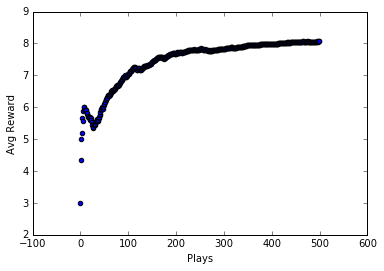

In [35]:
plt.xlabel("Plays")
plt.ylabel("Avg Reward")
for i in range(500):
    if random.random() > eps: #greedy selection
        choice = bestArm(av)
        thisAV = np.array([[choice, reward(arms[choice])]])
        av = np.concatenate((av, thisAV), axis=0)
    else: #random arm selection
        choice = np.where(arms == np.random.choice(arms))[0][0]
        thisAV = np.array([[choice, reward(arms[choice])]]) #choice, reward 
        av = np.concatenate((av, thisAV), axis=0) #add to our action-value memory array
    #calculate the percentage the correct arm is chosen (you can plot this instead of reward)
    percCorrect = 100*(len(av[np.where(av[:,0] == np.argmax(arms))])/len(av))
    #calculate the mean reward
    runningMean = np.mean(av[:,1])
    plt.scatter(i, runningMean)

## 增進一點效能

同樣的方法，改進前面算法中，每次 play 都需要被記錄，而且每次都需要掃過重頭到尾的紀錄去搜尋的缺點

 - 改成只記錄每台機器的最新平均分數，以及目前為止被選擇的次數 
 - 使用 np.average，讓計算平均時同樣考慮到每台機器被選擇的次數

In [57]:
n = 10
arms = np.random.rand(n)
eps = 0.1
av = np.ones(n) #initialize action-value array
counts = np.zeros(n) #stores counts of how many times we've taken a particular action

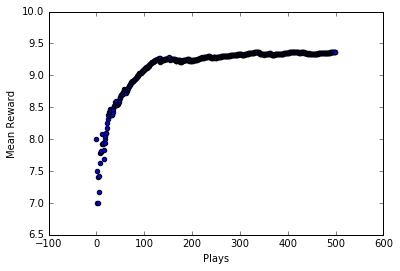

In [58]:
#our bestArm function is much simpler now
def bestArm(a):
    return np.argmax(a) #returns index of element with greatest value

plt.xlabel("Plays")
plt.ylabel("Mean Reward")
for i in range(500):
    if random.random() > eps:
        choice = bestArm(av)
        counts[choice] += 1
        k = counts[choice]
        rwd =  reward(arms[choice])
        old_avg = av[choice]
        new_avg = old_avg + (1/k)*(rwd - old_avg) #update running avg
        av[choice] = new_avg
    else:
        choice = np.where(arms == np.random.choice(arms))[0][0] #randomly choose an arm (returns index)
        counts[choice] += 1
        k = counts[choice]
        rwd =  reward(arms[choice])
        old_avg = av[choice]
        new_avg = old_avg + (1/k)*(rwd - old_avg) #update running avg
        av[choice] = new_avg
    #have to use np.average and supply the weights to get a weighted average
    runningMean = np.average(av, weights=np.array([counts[j]/np.sum(counts) for j in range(len(counts))]))
    plt.scatter(i, runningMean)

## Softmax Action Selection


在處理某些問題的過程中(ex. 醫療)，使用上述隨機探索的方式可能不太恰當，畢竟事情的嚴重性等級不同。因此使用 Softmax 給予個選項一個合理的機率值，一方面可以達到探索的效果，另一方面可以去避免犯下不該犯的錯誤。

*** Softmax 公式 ***


\begin{equation*}
\dfrac{e^{Q_k(a)/\tau}}{\sum\limits_{i=1}^n e^{Q_k(i)/\tau}}
\end{equation*}


In [71]:
n = 10
arms = np.random.rand(n)

av = np.ones(n) #initialize action-value array, stores running reward mean
counts = np.zeros(n) #stores counts of how many times we've taken a particular action
#stores our softmax-generated probability ranks for each action
av_softmax = np.zeros(n)
av_softmax[:] = 0.1 #initialize each action to have equal probability
tau = 1.12 #tau was selected by trial and error

In [72]:
def softmax(av):
    probs = np.zeros(n)
    for i in range(n):
        softm = ( np.exp(av[i] / tau) / np.sum( np.exp(av[:] / tau) ) )
        probs[i] = softm
    return probs

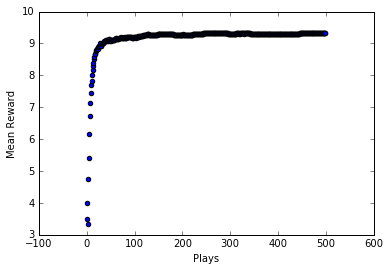

In [73]:
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
for i in range(500):
    #select random arm using weighted probability distribution
    choice = np.where(arms == np.random.choice(arms, p=av_softmax))[0][0]
    counts[choice] += 1
    k = counts[choice]
    rwd =  reward(arms[choice])
    old_avg = av[choice]
    new_avg = old_avg + (1/k)*(rwd - old_avg)
    av[choice] = new_avg
    av_softmax = softmax(av) #update softmax probabilities for next play

    runningMean = np.average(av, weights=np.array([counts[j]/np.sum(counts) for j in range(len(counts))]))
    plt.scatter(i, runningMean)